In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
# os.environ.clear()
load_dotenv('env', override=True)
load_dotenv('env.secret', override=True) # Ignored in git

pd.options.display.max_rows = 999

In [2]:
from aiutils.constants import c
from aiutils import aiwr
import pandas as pd

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import dgl
from dgl.nn.pytorch.hetero import HeteroGraphConv
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import itertools

Using backend: pytorch


In [5]:
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

---

In [6]:
data = 'gs://ue4_ndlk_nonprod_stg_gcs_iadev_adsto/tmp/AlejandroJ/gnn-recommender/vigencias_prod.parquet'

In [7]:
df = pd.read_parquet(data)

In [8]:
df.shape

(2146796, 2)

In [103]:
df.id_producto.nunique()

141

In [101]:
df

,id_persona,id_producto,encoded_client,encoded_product
0,AX-24565258,AX-8744,682664,102
1,AX-24992670,AX-7910,703929,66
2,AX-2865889,AX-8401,879016,94
3,AX-5884330,AX-8010,1449990,72
4,AX-1929897,AX-9037,438668,133
...,...,...,...,...
2146791,AX-31333616,AX-9102,1160682,138
2146792,AX-6185717,AX-9102,1474872,138
2146793,AX-3544689,AX-9102,1206987,138
2146794,AX-12615620,AX-9102,176876,138


In [9]:
encoders = {
    'client': preprocessing.LabelEncoder(),
    'product': preprocessing.LabelEncoder(),
}

In [10]:
df['encoded_client'] = encoders['client'].fit_transform(df['id_persona'])
df['encoded_product'] = encoders['product'].fit_transform(df['id_producto'])

### 1. graph definition

In [11]:
data_dict = {
    ('client', 'owns', 'product'): (torch.tensor(df.encoded_client), torch.tensor(df.encoded_product)),
    ('product', 'owned-by', 'client'): (torch.tensor(df.encoded_product), torch.tensor(df.encoded_client))
}

#num_nodes_dict = {'user': df.userId.nunique(), 'movie': df.movieId.nunique()}

g = dgl.heterograph(data_dict)

#### train test split

In [12]:
def neg_sampler(u,v, etype, test_size):
    
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
    adj_neg = -1*adj.todense()+1
    neg_u, neg_v = np.where(adj_neg != 0)
    
    num_edges = u.size(0)
    
    neg_eids = np.random.choice(len(neg_u), num_edges)
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
    
    
    return train_neg_u, train_neg_v, test_neg_u, test_neg_v

In [13]:
train_test = {etype:dict() for etype in g.etypes}

In [14]:
for etype in g.etypes:
    u, v = g[etype].edges()
    
    train_test[etype]['u'] = u
    train_test[etype]['v'] = v
    
    eids = np.arange(g.number_of_edges(etype))
    eids = np.random.permutation(eids)
    
    train_test[etype]['eids'] = eids
    
    # 20% test
    test_perc = 0.2
    test_size = int(len(eids) * test_perc)
    train_test[etype]['test_size'] = test_size
    
    
    train_size = g.number_of_edges(etype) - test_size
    
    
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    
    train_neg_u, train_neg_v, test_neg_u, test_neg_v = neg_sampler(u,v, etype, test_size)
    
    
    train_test[etype]['train_pos_u'] = train_pos_u
    train_test[etype]['train_pos_v'] = train_pos_v
    train_test[etype]['train_neg_u'] = train_neg_u
    train_test[etype]['train_neg_v'] = train_neg_v
    
    
    train_test[etype]['test_pos_u'] = test_pos_u
    train_test[etype]['test_pos_v'] = test_pos_v
    train_test[etype]['test_neg_u'] = test_neg_u
    train_test[etype]['test_neg_v'] = test_neg_v
    
#     # positive and negative graphs
#     train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
#     train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

#     test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
#     test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())
    
#     train_test[etype]['train_pos_g'] = train_pos_g
#     train_test[etype]['train_neg_g'] = train_neg_g
    
#     train_test[etype]['test_pos_g'] = test_pos_g
#     train_test[etype]['test_neg_g'] = test_neg_g
    

In [15]:
train_test['owns'].keys()

dict_keys(['u', 'v', 'eids', 'test_size', 'train_pos_u', 'train_pos_v', 'train_neg_u', 'train_neg_v', 'test_pos_u', 'test_pos_v', 'test_neg_u', 'test_neg_v'])

#### remove test edges for each edge type

In [16]:
train_g = g
for etype in g.etypes:
    train_g = dgl.remove_edges(train_g, train_test[etype]['eids'][:train_test[etype]['test_size']], etype=etype)
    

In [17]:
### HARDCODED
data_dict = {
    ('client', 'owns', 'product'): (train_test['owns']['train_pos_u'], train_test['owns']['train_pos_v']),
    ('product', 'owned-by', 'client'): ((train_test['owned-by']['train_pos_u'], train_test['owned-by']['train_pos_v']))
}

train_pos_g = dgl.heterograph(data_dict)

In [18]:
### HARDCODED
data_dict = {
    ('client', 'owns', 'product'): (train_test['owns']['train_neg_u'], train_test['owns']['train_neg_v']),
    ('product', 'owned-by', 'client'): ((train_test['owned-by']['train_neg_u'], train_test['owned-by']['train_neg_v']))
}

train_neg_g = dgl.heterograph(data_dict)

test

In [19]:
### HARDCODED
data_dict = {
    ('client', 'owns', 'product'): (train_test['owns']['test_pos_u'], train_test['owns']['test_pos_v']),
    ('product', 'owned-by', 'client'): ((train_test['owned-by']['test_pos_u'], train_test['owned-by']['test_pos_v']))
}

test_pos_g = dgl.heterograph(data_dict)



### HARDCODED
data_dict = {
    ('client', 'owns', 'product'): (train_test['owns']['test_neg_u'], train_test['owns']['test_neg_v']),
    ('product', 'owned-by', 'client'): ((train_test['owned-by']['test_neg_u'], train_test['owned-by']['test_neg_v']))
}

test_neg_g = dgl.heterograph(data_dict)

In [21]:
g

Graph(num_nodes={'client': 1815945, 'product': 141},
      num_edges={('client', 'owns', 'product'): 2146796, ('product', 'owned-by', 'client'): 2146796},
      metagraph=[('client', 'product', 'owns'), ('product', 'client', 'owned-by')])

In [20]:
train_g

Graph(num_nodes={'client': 1815945, 'product': 141},
      num_edges={('client', 'owns', 'product'): 1717437, ('product', 'owned-by', 'client'): 1717437},
      metagraph=[('client', 'product', 'owns'), ('product', 'client', 'owned-by')])

In [22]:
train_pos_g

Graph(num_nodes={'client': 1815945, 'product': 141},
      num_edges={('client', 'owns', 'product'): 1717437, ('product', 'owned-by', 'client'): 1717437},
      metagraph=[('client', 'product', 'owns'), ('product', 'client', 'owned-by')])

In [23]:
train_neg_g

Graph(num_nodes={'client': 1815945, 'product': 141},
      num_edges={('client', 'owns', 'product'): 1717437, ('product', 'owned-by', 'client'): 1717437},
      metagraph=[('client', 'product', 'owns'), ('product', 'client', 'owned-by')])

---

#### model def

In [24]:
from dgl.nn import SAGEConv

class GraphSAGEHetero(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGEHetero, self).__init__()
        self.conv1 = HeteroGraphConv({'owns' : dgl.nn.SAGEConv(in_feats,h_feats, aggregator_type='mean'),
                                     'owned-by': dgl.nn.SAGEConv(in_feats,h_feats, aggregator_type='mean')}, aggregate='sum')
        
        self.conv2 = HeteroGraphConv({'owns' : dgl.nn.SAGEConv(h_feats,h_feats, aggregator_type='mean'),
                                     'owned-by': dgl.nn.SAGEConv(h_feats,h_feats, aggregator_type='mean')})
    
    
    def forward(self, g, x):
        x = self.conv1(g, x)
        
        for k in x.keys():
            x[k] = F.relu(x[k])
        
        x = self.conv2(g, x)
        
        return x

In [25]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h, etype):
        u,v = g[etype].edges()
        
        if etype =='owns':
            src = h['client'][u]
            dst = h['product'][v]
            
        elif etype =='owned-by':
            src = h['product'][u]
            dst = h['client'][v]
            
        
        return (src * dst).sum(dim=1)

In [26]:
gnn = GraphSAGEHetero(16, 32)

In [27]:
client_feat = nn.Embedding(g.num_nodes('client'), 16)
product_feat = nn.Embedding(g.num_nodes('product'), 16)

In [28]:
x = dict()

x['client'] = client_feat.weight
x['product'] = product_feat.weight

In [29]:
### FORWARD
gnn(train_g, x).keys()

dict_keys(['client', 'product'])

---

In [30]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [55]:
# enrich
client_feat = nn.Embedding(g.num_nodes('client'), 16)
product_feat = nn.Embedding(g.num_nodes('product'), 16)

model = GraphSAGEHetero(16, 32)
pred = DotPredictor()

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), 
                                             pred.parameters(), 
                                             client_feat.parameters(), 
                                             product_feat.parameters()), 
                             lr=0.01)

In [56]:
x = dict()

x['client'] = client_feat.weight
x['product'] = product_feat.weight

In [57]:
for e in range(50):
    # forward
    h = model(train_g, x)
    
    # pos and neg score for each edge type
    pos_list = []
    neg_list = []
    
    for etype in g.etypes:
        pos_list.append(pred(train_pos_g, h, etype))
        neg_list.append(pred(train_neg_g, h, etype))
    
    pos_score = torch.cat(pos_list, dim=0)
    neg_score = torch.cat(neg_list, dim=0)
    
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))
        print('TRAIN AUC', compute_auc(pos_score, neg_score))
        
        ### TEST AUC
        pos_list = []
        neg_list = []

        for etype in g.etypes:
            p = pred(test_pos_g, h, etype)
            pos_list.append(p)

            n = pred(test_neg_g, h, etype)
            neg_list.append(n)


        pos_score = torch.cat(pos_list, dim=0)
        neg_score = torch.cat(neg_list, dim=0)

        print('TEST AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 5.757626533508301
TRAIN AUC 0.43949641223049923
TEST AUC 0.48455257089663384


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 5, loss: 0.9769274592399597
TRAIN AUC 0.8851688701231153
TEST AUC 0.8032078535471896


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 10, loss: 0.5731887221336365
TRAIN AUC 0.9490338328166471
TEST AUC 0.8535329913117985


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 15, loss: 0.37473851442337036
TRAIN AUC 0.9700062225488575
TEST AUC 0.9072021120093579


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 20, loss: 0.24701200425624847
TRAIN AUC 0.9799593699006874
TEST AUC 0.9261211876212191


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 25, loss: 0.21463130414485931
TRAIN AUC 0.9830842927474936
TEST AUC 0.9334549001432946


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 30, loss: 0.17225104570388794
TRAIN AUC 0.9866931062612082
TEST AUC 0.9457329202578872


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 35, loss: 0.15153586864471436
TRAIN AUC 0.9889330665015053
TEST AUC 0.95219653125531


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 40, loss: 0.13350020349025726
TRAIN AUC 0.9901425966702069
TEST AUC 0.953722336183924


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 45, loss: 0.12248189747333527
TRAIN AUC 0.9911421746456522
TEST AUC 0.9551160573369488


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


---

#### test

In [64]:
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    h = model(train_g, x)
    
    # pos and neg score for each edge type
    pos_list = []
    neg_list = []
    
    for etype in g.etypes:
        p = pred(test_pos_g, h, etype)
        pos_list.append(p)
        
        n = pred(test_neg_g, h, etype)
        neg_list.append(n)
        
        
    pos_score = torch.sigmoid(torch.cat(pos_list, dim=0))
    neg_score = torch.sigmoid(torch.cat(neg_list, dim=0))
        
    print('AUC', compute_auc(pos_score, neg_score))

AUC 0.9582923557010946


In [93]:
neg_score

tensor([1.9482e-04, 5.6148e-02, 3.2993e-04,  ..., 3.8056e-08, 4.3984e-02,
        4.2163e-08])

In [66]:
negs = pd.Series(neg_score.numpy())

<AxesSubplot:ylabel='Frequency'>

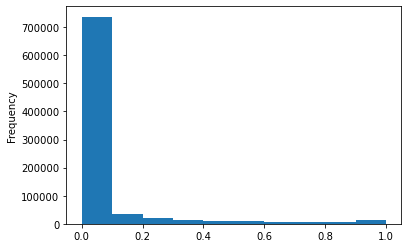

In [67]:
negs.plot.hist()

In [92]:
pos_score

tensor([0.9999, 1.0000, 0.9991,  ..., 0.6002, 0.2693, 0.5786])

In [99]:
pos = pd.Series(pos_score.numpy())

<AxesSubplot:ylabel='Frequency'>

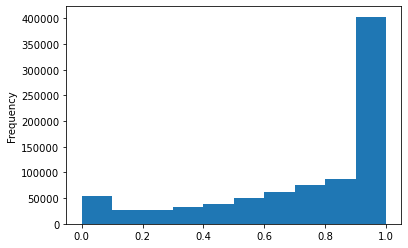

In [100]:
pos.plot.hist()